In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dali.core as D
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from dali.models import MLP
from dali.utils import Solver
from IPython.display import clear_output, display, HTML

import svg

In [214]:
D.config.default_device = 'cpu'

In [198]:
import time

from queue import PriorityQueue

class EqItem(object):
    def __init__(self, ts, f):
        self.ts = ts
        self.f  = f
        
    def __lt__(self, other):
        return self.ts < other.ts
    
    def __eq__(self, other):
        return self.ts == other.ts

class EventQueue(object):
    def __init__(self):
        self.q = PriorityQueue()
    
    def schedule(self, f, ts):
        self.q.put(EqItem(ts, f))
        
    def schedule_recurring(self, f, interval):
        def recuring_f():
            f()
            self.schedule(recuring_f, time.time() + interval)
        self.schedule(recuring_f, time.time() + interval)
        
        
    def run(self):
        while True:
            event = self.q.get()
            now = time.time()
            if now < event.ts:
                time.sleep(event.ts - now)
            event.f()
            
eq.schedule_recurring(lambda: print("siema", flush=True), 1)
eq.run()


siema
siema
siema
siema
siema
siema


KeyboardInterrupt: 

In [184]:
from collections import deque

class DeepQ(object):
    def __init__(self, observation_size,
                       num_actions,
                       observation_to_actions,
                       solver,
                       random_action_probability=0.05,
                       exploration_period=1000,
                       minibatch_size=30,
                       discount_rate=0.95,
                       max_experience=20000):
        # memorize arguments
        self.observation_size          = observation_size
        self.num_actions               = num_actions
        
        self.observation_to_actions    = observation_to_actions
        self.solver                    = solver
        
        self.random_action_probability = random_action_probability
        self.exploration_period        = exploration_period
        self.minibatch_size            = minibatch_size
        self.discount_rate             = discount_rate
        self.max_experience            = max_experience
        
        # deepq state
        self.actions_executed_so_far = 0
        self.experience = deque()
        
    def linear_annealing(self, n, total, p_initial, p_final):
        if n >= total:
            return p_final
        else:
            return p_initial - (n * (p_initial - p_final)) / (total)

    def activate(self, observation):
        action_scores = self.observation_to_actions.activate(observation)
        assert action_scores.shape[1] == self.num_actions, \
                "number of columns in the output of `observation_to_actions` must be equal to number of actions."
        assert action_scores.shape[0] == observation.shape[0], \
                "number of output rows of `observation_to_actions` must be equal to number of input rows"
        return action_scores
    
    def action(self, observation):
        assert len(observation.shape) == 1, \
                "Action is performed based on single observation."

        self.actions_executed_so_far += 1
        exploration_p = self.linear_annealing(self.actions_executed_so_far,
                                              self.exploration_period,
                                              1.0,
                                              self.random_action_probability)
                                                 
        if random.random() < exploration_p:
            return random.randint(0, self.num_actions - 1)
        else:
            with D.NoBackprop():
                observation_dali = D.Mat(observation[np.newaxis,:], constant=True)
                assert observation_dali.shape == (1, observation.shape[0])
                action_scores = self.activate(observation_dali)
                return D.MatOps.argmax(action_scores, axis=1)[0]
        
    def store(self, state, action, reward, newstate):
        """Store experience. 
        
        If newstate is None, the state/action pair is assumed to be terminal."""
        self.experience.append((state, action, reward, newstate))
        if len(self.experience) > self.max_experience:
            self.experience.popleft()
    
    def training_step(self):
        if len(self.experience) <  self.minibatch_size:
            return
        
        # sample experience. 
        samples   = random.sample(range(len(self.experience)), self.minibatch_size)
        samples   = [self.experience[i] for i in samples]
        
        # bach states
        states    = np.empty((len(samples), self.observation_size))
        newstates = np.empty((len(samples), self.observation_size))
        action_mask    = np.zeros((len(samples), self.num_actions))
        
        newstates_mask = np.empty((len(samples),))
        rewards        = np.empty((len(samples),))
        
        for i, (state, action, reward, newstate) in enumerate(samples):
            states[i] = state
            action_mask[i] = 0
            action_mask[i][action] = 1
            rewards[i] = reward
            if newstate is not None:
                newstates[i] = state
                newstates_mask[i] = 1
            else:
                newstates[i] = 0
                newstates_mask[i] = 0
                
        # convert to dali, steal numpy memory, do not compute gradient (that's constant)
        states      = D.Mat(states,      borrow=True, constant=True)
        newstates   = D.Mat(newstates,   borrow=True, constant=True)
        action_mask = D.Mat(action_mask, borrow=True, constant=True)
        
        # compute target value functions
        with D.NoBackprop():
            action_scores = self.activate(newstates)
        # rowwise max - best achievable value function for each sample.
        newstates_value = action_scores.w.max(axis=1) * newstates_mask
        targets = rewards + self.discount_rate * newstates_value

        # convert to dali, steal numpy memory, do not compute gradient (that's constant)
        targets     = D.Mat(targets,     borrow=True, constant=True)
        
        # this computation will be backpropagated.
        action_scores = self.activate(states)
        relevant_actions = (action_scores * action_mask).sum(axis=1)
        error = (relevant_actions - targets)**2
        error.grad()
        
        # compute gradient
        D.Graph.backward()
        # apply gradient
        solver.step()    

In [91]:
if False:
    brain = MLP([3,], [3,3,5], [D.MatOps.tanh, D.MatOps.tanh, lambda x: x])
    solver = Solver(brain.parameters(), "rmsprop_momentum")
    controller = DeepQ(3, 5, brain, solver)
    for _ in range(30):
        observation = np.random.uniform(-1, 1, size=(3,))
        best_action = controller.action(observation)
        reward = 10
        new_state = np.random.uniform(-1, 1, size=(3,))
        controller.store(observation, best_action, reward, new_state)


In [93]:
# geometry
def point_distance(x, y):
    return np.linalg.norm(x-y)

def point_projected_on_line(line_s, line_e, point):
    line_along = line_e - line_s
    
    transformed_point = point - line_s
    
    point_dot_line  = np.dot(transformed_point, line_along)
    line_along_norm = np.dot(line_along, line_along)
    
    transformed_projection = (point_dot_line / line_along_norm) * line_along
    
    return transformed_projection + line_s

def point_segment_distance(segment_s, segment_e, point):
    projected = point_projected_on_line(segment_s, segment_e, point)
    if np.isclose(point_distance(segment_s, projected) + point_distance(projected, segment_e),
                  point_distance(segment_s, segment_e)):
        # projected on segment
        return point_distance(point, projected)
    else:
        return min(point_distance(point, segment_s), point_distance(point, segment_e))

In [244]:
SETTINGS = {
    'colors': {
        'hero': 'yellow',
        'friend': 'green',
        'enemy':  'red',
        'boss':   'orange',
    },
    'object_reward': {
        'friend': 5,
        'enemy': -6,
        'boss':  -100,
    },
    'observation_repr_size': 4,
    'observation_repr': {
        'friend':  np.array([1,0,0,0]),
        'enemy':   np.array([0,1,0,0]),
        'boss':    np.array([0,0,1,0]),
        'wall':    np.array([0,0,0,1]),
        'nothing': np.array([0,0,0,0]),
    },
#     'observation_repr_size': 1,
#     'observation_repr': {
#         'friend':  np.array([0,]),
#         'enemy':   np.array([0,]),
#         'wall':    np.array([1,]),
#         'nothing': np.array([0,]),
#     },
    'world_size': (600,400),
    'resolution': 0.001,
    'fps': 60, 
    'hero_initial_position': [570, 200],
    'hero_initial_speed':    [100, 100],
    "object_radius": 10,
    "num_objects": {
        "friend" : 10,
        "enemy" :  10,
        "boss" :   3,
    },
    "num_observation_lines" : 16,
    "observation_line_length": 70,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -1.0,
}



class GameObject(object):
    def __init__(self, position, speed, obj_type, settings):
        self.settings = settings
        self.radius = self.settings["object_radius"]
        
        self.obj_type = obj_type
        self.position = np.array(position, dtype=float)
        self.speed = np.array(speed, dtype=float)
        
    def wall_collisions(self):
        world_size = self.settings["world_size"]
        for dim in range(2):
            if self.position[dim] - self.radius       <= 0               and self.speed[dim] < 0:
                self.speed[dim] = - self.speed[dim]
            elif self.position[dim] + self.radius + 1 >= world_size[dim] and self.speed[dim] > 0:
                self.speed[dim] = - self.speed[dim]
        
    def move(self, dt):
        self.position += dt * self.speed
        
    def step(self, dt):
        self.wall_collisions()
        self.move(dt)
        
    def draw(self):
        color = self.settings["colors"][self.obj_type]
        return svg.Circle(self.position.astype(int) + 10, self.radius, color=color)

class KarpathyGame(object):
    def __init__(self, settings):
        self.settings = settings
        self.size = np.array(self.settings["world_size"])
        self.resoution = self.settings["resolution"]
        
        self.hero = GameObject(self.settings["hero_initial_position"].copy(),
                               self.settings["hero_initial_speed"].copy(),
                               "hero",
                               self.settings)
        
        self.objects = []
        for obj_type, number in settings["num_objects"].items():
            for _ in range(number):
                self.spawn_object(obj_type)
        
        self.observation_lines = self.generate_observation_lines()
        
        self.object_reward = 0
        self.collected_rewards = []
        
        self.observation_size = self.settings["observation_repr_size"] * len(self.observation_lines)
        self.num_actions      = 4
        
    def perform_action(self, action_id):
        if action_id == 0:
            self.hero.speed = np.array([100, 0])
        elif action_id == 1:
            self.hero.speed = np.array([-100, 0])
        elif action_id == 2:
            self.hero.speed = np.array([0, 100])
        elif action_id == 3:
            self.hero.speed = np.array([0, -100])
        else:
            assert False
            
    def spawn_object(self, obj_type):
        radius = self.settings["object_radius"]
        position = np.random.uniform([radius, radius], self.size - radius).astype(float)
        speed    = np.random.uniform([-100,-100], [100,100]).astype(float)
        self.objects.append(GameObject(position, speed, obj_type, self.settings))     
                
    def step(self, dt):
        for obj in self.objects + [self.hero] :
            obj.step(dt)
        self.resolve_collisions()

    def resolve_collisions(self):
        to_remove = []
        for obj in self.objects:
            if np.linalg.norm(obj.position - self.hero.position) < 2 * self.settings["object_radius"]:
                to_remove.append(obj)
        for obj in to_remove:
            self.objects.remove(obj)
            self.object_reward += self.settings["object_reward"][obj.obj_type]
            self.spawn_object(obj.obj_type)
        
    def inside_walls(self, point):
        return np.all(np.array([0,0]) <= point) and np.all(point < self.size)
        
    def observe(self):
        observable_distance = self.settings["object_radius"] + self.settings["observation_line_length"]
        relevant_objects = [obj for obj in self.objects 
                            if point_distance(obj.position, self.hero.position) < observable_distance]
        # objects sorted from closest to furthest
        relevant_objects.sort(key=lambda x: point_distance(x.position, self.hero.position))
        observ_atom_sz = self.settings["observation_repr_size"]
        observation = np.zeros((observ_atom_sz * len(self.observation_lines),))
        for i, (line_start, line_end) in enumerate(self.observation_lines):
            line_start = line_start + self.hero.position
            line_end   = line_end   + self.hero.position
            observed_repr = self.settings["observation_repr"]["nothing"]
            if not self.inside_walls(line_end):
                observed_repr = self.settings["observation_repr"]["wall"]
            for obj in relevant_objects:
                if point_segment_distance(line_start, line_end, obj.position) < SETTINGS["object_radius"]:
                    observed_repr = self.settings["observation_repr"][obj.obj_type]
                    break
            observation[i*observ_atom_sz:(i+1)*observ_atom_sz] = observed_repr
        return observation        
    
    def distance_to_walls(self):
        tl = np.min(self.hero.position - self.settings["object_radius"])
        br = np.min(self.size - self.hero.position - self.settings["object_radius"])
        return np.min([tl,br])
        
    def collect_reward(self):
        wall_reward =  self.settings["wall_distance_penalty"] * \
                       np.exp(-self.distance_to_walls() / self.settings["tolerable_distance_to_wall"])
        total_reward = wall_reward + self.object_reward
        self.object_reward = 0
        self.collected_rewards.append(total_reward)
        return total_reward
        
    def plot_reward(self, smoothing = 30):
        plottable = self.collected_rewards[:]
        while len(plottable) > 1000:
            for i in range(0, len(plottable) - 1, 2):
                plottable[i//2] = (plottable[i] + plottable[i+1]) / 2
            plottable = plottable[:(len(plottable) // 2)]
        x = []
        for  i in range(smoothing, len(plottable)):
            chunk = plottable[i-smoothing:i]
            x.append(sum(chunk) / len(chunk))
        plt.plot(list(range(len(x))), x)
        
    def generate_observation_lines(self):
        result = []
        start = np.array([self.settings["object_radius"]* 1.1, self.settings["object_radius"]* 1.1])
        end   = np.array([self.settings["object_radius"] + self.settings["observation_line_length"],
                          self.settings["object_radius"] + self.settings["observation_line_length"]])
        for angle in np.linspace(0, 2*np.pi, self.settings["num_observation_lines"], endpoint=False):
            rotation = np.array([np.cos(angle), np.sin(angle)])
            result.append((start * rotation, end * rotation))
        return result
        
    def _repr_html_(self):
        return self.to_html()
    
    def to_html(self, stats):
        scene = svg.Scene((self.size[0] + 20, self.size[1] + 20 + 20 * len(stats)))
        scene.add(svg.Rectangle((10, 10), self.size))
        for obj in self.objects + [self.hero] :
            scene.add(obj.draw())
            
        for line_start, line_end in self.observation_lines:
            scene.add(svg.Line(line_start + self.hero.position + 10, line_end + self.hero.position + 10))
        
        offset = self.size[1] + 15
        for txt in stats:              
            scene.add(svg.Text((10, offset + 20), txt, 15))
            offset += 20
                          
        return scene
        

In [245]:
g = KarpathyGame(SETTINGS)

In [246]:
brain = MLP([g.observation_size,], [100, g.num_actions], [D.MatOps.tanh, lambda x: x])
# brain = MLP([g.observation_size,], [g.num_actions], [lambda x: x])
solver = Solver(brain.parameters(), "sgd", learning_rate=0.01)
c = DeepQ(g.observation_size, g.num_actions, brain, solver, max_experience=30000)

In [249]:
def simulate(game, controller, fps=60, actions_per_second=60, simulation_resultion=0.001, speed=1.0):
    eq = EventQueue()
    
    time_between_frames  = 1.0 / fps
    time_between_actions = 1.0 / (actions_per_second * speed)
    
    def visualize():
        clear_output(wait=True)
        recent_reward = game.collected_rewards[-100:] + [0]
        display(game.to_html([
            "DTW        = %.1f" % (game.distance_to_walls(),),
            "experience = %d" % (len(controller.experience),),
            "reward = %.1f" % (sum(recent_reward)/len(recent_reward),),

        ]))
    eq.schedule_recurring(visualize, time_between_frames)
        
    simulated_up_to = time.time()

    def simulate_game():
        nonlocal simulated_up_to
        now = time.time()
        time_to_be_simulated = speed * (now - simulated_up_to)
        for _ in range(int(time_to_be_simulated / simulation_resultion)):
            game.step(simulation_resultion)
        simulated_up_to = now
        
    eq.schedule_recurring(simulate_game, min(time_between_frames, time_between_actions))

    
    last_observation = None
    last_action      = None
    
    def control():
        nonlocal last_observation
        nonlocal last_action
        # sense
        new_observation = game.observe()
        reward          = game.collect_reward()
        # store last transition
        if last_observation is not None:
            controller.store(last_observation, last_action, reward, new_observation)
        # act
        new_action = controller.action(new_observation)
        game.perform_action(new_action)
        last_action = new_action
        last_observation = new_observation
        
        #train
        controller.training_step()
    
    eq.schedule_recurring(control, time_between_actions)
    
    eq.run()
    
simulate(g, c, fps = 30, simulation_resultion=0.01, actions_per_second=15, speed=1.0)

KeyboardInterrupt: 

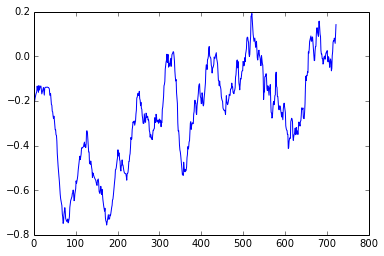

In [242]:
g.plot_reward()

In [122]:
np.all(np.array([0,0]) <= np.array([0,0])) and 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

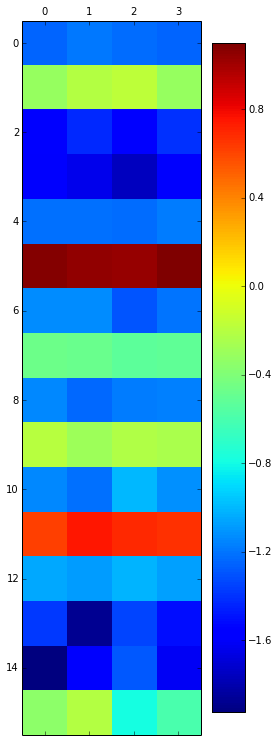

In [228]:
# left, right, up, down
plt.matshow(c.observation_to_actions.parameters()[0].w)
plt.colorbar()

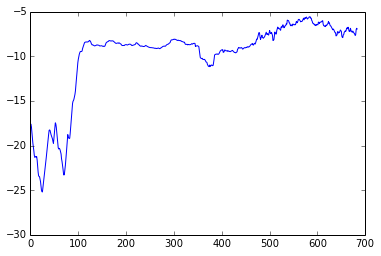

In [170]:
g.plot_reward()

In [259]:
?np.linspace

In [507]:
def get(n, total, p_initial, p_final):
    if n >= total:
        return p_final
    else:
        return p_initial - (n * (p_initial - p_final)) / (total)

In [511]:
get(0, 100, 2.0, 0.05)

2.0

In [173]:
x = [1,2,3]

In [179]:
x = deque()

In [197]:
class Siema(object):
    def __init__(self, n):
        self.n = n 
        
    def __lt__(self, other):
        return self.n < other.n
    
    def __repr__(self):
        return str(self.n)

x = [Siema(123), Siema(4), Siema(1), Siema(6)]
sorted(x)

[1, 4, 6, 123]